In [1]:
from All_functions_simulation_univariate import * 
from sklearn.linear_model import QuantileRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [2]:
################################### Data Generating ###################################

def myData(i, n=2200):
    """
    i: random seed
    n: number of samples
    """
    np.random.seed(i)
    X = np.random.uniform(-1, 1, n).reshape(-1, 1)
    Y = 1+5*np.power(X, 3)+np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)
    
    return X, Y

In [ ]:
################################### Different Methods ###################################

def UTOPIA(X,Y,alpha = 0.05,n_pre = 1000,n_opt = 100,n_adj = 100,n_t = 1000,known_mean = "False"):
    """
    X,Y: input data
    alpha: coverage level
    """
    X_pre = X[0:n_pre,:].reshape(-1, 1)
    Y_pre = Y[0:n_pre,:].reshape(-1, 1)

    X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
    Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

    X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
    Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


    X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    
    # Obtain mean estimator
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,max_depth = 5, est_type ="RF")
    
    # Obtain quantile estimators
    quantile = [0.8,0.85,0.9,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)
    
    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1,1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1,1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1,1)))
    E_t = E_t.T
    
    # solve optimization problem
    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    #optimal_weight, V100_adj, V100_t = solve_opt_slack(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

    # adjust interval
    alpha = 0.05
    delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)
    V_alpha_t = delta*V100_t
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    return coverage, bandwidth



def LQR(X,Y,alpha = 0.05,n_mean = 600,n_quantile = 600,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_mean,:]
    Y_mean = Y[0:n_mean,:]
    x_mean = X_mean[:,0]
    y_mean = Y_mean[:,0]

    X_quantile = X[n_mean:n_mean+n_quantile,:]
    Y_quantile = Y[n_mean:n_mean+n_quantile,:]

    X_test = X[n_mean+n_quantile:,:]
    Y_test = Y[n_mean+n_quantile:,:]

    # Estimate the mean
    if known_mean == "True":
        M_quantile = np.zeros(n_quantile).reshape(-1,1)
        M_test = np.zeros(n_test).reshape(-1,1)
    else:
        est_type = "NN2"
        M_quantile, M_test = mean_est_2(est_type,X_mean,Y_mean,X_quantile,X_test)
        
    # Estimate the quantile
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)
    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    
    return coverage, bandwidth



def SplitCF(X,Y,alpha = 0.05,n_mean = 600,n_res = 600,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_mean,:]
    Y_mean = Y[0:n_mean,:]

    X_res = X[n_mean:n_mean+n_res,:]
    Y_res = Y[n_mean:n_mean+n_res,:]

    X_test = X[n_mean+n_res:,:]
    Y_test = Y[n_mean+n_res:,:]

    ##### Estimating the mean function ######

    if known_mean == "True":
        Y_mean_hat = np.zeros(n_mean).reshape(-1,1)
        Y_res_hat = np.zeros(n_res).reshape(-1,1)
        Y_test_hat = np.zeros(n_test).reshape(-1,1)

    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        input_dim = X_mean.shape[1]
        model = NN2(input_size=input_dim, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(1000):
            inputs=Variable(torch.from_numpy(X_mean))
            labels=Variable(torch.from_numpy(Y_mean))
            optimizer.zero_grad()
            outputs=model(inputs.float())
            loss=criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

        Y_mean_hat = model(torch.from_numpy(X_mean).float())
        Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

        Y_res_hat = model(torch.from_numpy(X_res).float())
        Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

        Y_test_hat = model(torch.from_numpy(X_test).float())
        Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


    ################## Estimating the variance function #####################

    resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]
    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
    var_model.fit(X_mean, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_mean)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)

    ################### Calculating the residuals ##########################

    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * n_res)
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    coverage = (np.abs(Y_test[:,0]- Y_test_hat[:,0])/((var_test_hat ** 0.5) + 1e-10) <= threshold).mean()
    bandwidth = np.mean(var_test_hat * (threshold ** 2))

    return coverage, bandwidth
    

    
# Solve optimization problem in Liang's paper
def sdpDual(K, Y):
    n = Y.shape[0]
    y = Y[:,0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB)), constraints)
    prob.solve()
    return hB.value
    
def SDP(X,Y,alpha = 0.05,n_pre = 1000,n_opt = 100,n_adj = 100,n_t = 1000,known_mean = "False", sigma = 1):
    """
    Liang's method with Gaussian kernel
    sigma: parameter for the Gaussian kernel
    """
    
    X_pre = X[0:n_pre,:].reshape(-1, 1)
    Y_pre = Y[0:n_pre,:].reshape(-1, 1)

    X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
    Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

    X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
    Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


    X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
    output = sdpDual(K_opt, Y_opt-M_opt)
        
    K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
    shape_adj = K_adj @ output @ K_adj.T
    shape_adj = shape_adj.diagonal()
        
    K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
    shape_t = K_t @ output @ K_t.T
    shape_t = shape_t.diagonal()

    delta = -1
    Delta = 0
    prop = 0.5
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    while prop_outside > (0.75 * alpha) and delta != Delta:
        delta = prop * delta + (1 - prop) * Delta
        prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()


    V_alpha_t = (1 + delta) * shape_t
    V_alpha_t = V_alpha_t.reshape(-1,1)

    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    return coverage, bandwidth

In [ ]:
################################### Repeat Simulation ###################################

times = 200



def run_utopia(i):
    X,Y = myData(i,n=3000)
    UTOPIA_cover, UTOPIA_wide = UTOPIA(X,Y,n_pre = 1000, n_opt=500, n_adj=500, known_mean ="False")
    LQR_cover, LQR_wide = LQR(X,Y,n_mean = 1000, n_quantile = 1000, known_mean ="False")
    SplitCF_cover, SplitCF_wide = SplitCF(X,Y,n_mean = 1000, n_res = 1000,known_mean ="False")
    SDP_cover, SDP_wide = SDP(X,Y,n_pre = 1000, n_opt=100, n_adj=900,known_mean ="False")
    
    return UTOPIA_cover, UTOPIA_wide, LQR_cover, LQR_wide, SplitCF_cover, SplitCF_wide, SDP_cover, SDP_wide

from joblib import Parallel, delayed
results = Parallel(n_jobs=10)(delayed(run_utopia)(i) for i in range(times))


In [ ]:
################################### Results ###################################

print("For UTOPIA:")
print("The mean of the coverage is", np.mean(np.array(results)[:,0]))
print("The median of the coverage is",np.median(np.array(results)[:,0]))
print("The SD of the coverage is", np.std(np.array(results)[:,0]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,0], [75, 25])))

print("The mean of the bandwidth is", np.mean(np.array(results)[:,1]))
print("The median of the bandwidth is", np.median(np.array(results)[:,1]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,1]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,1], [75, 25])))



print("For LQR:")
print("The mean of the coverage is", np.mean(np.array(results)[:,2]))
print("The median of the coverage is", np.median(np.array(results)[:,2]))
print("The SD of the coverage is", np.std(np.array(results)[:,2]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,2], [75, 25])))

print("The mean of the bandwidth is", np.mean(np.array(results)[:,3]))
print("The median of the bandwidth is", np.median(np.array(results)[:,3]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,3]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,3], [75, 25])))

print("For SplitCF:")
print("The mean of the coverage is", np.mean(np.array(results)[:,4]))
print("The median of the coverage is", np.median(np.array(results)[:,4]))
print("The SD of the coverage is", np.std(np.array(results)[:,4]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,4], [75, 25])))

print("The mean of the bandwidth is", np.mean(np.array(results)[:,5]))
print("The median of the bandwidth is", np.median(np.array(results)[:,5]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,5]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,5], [75, 25])))

print("For SDP:")
print("The mean of the coverage is", np.mean(np.array(results)[:,6]))
print("The median of the coverage is", np.median(np.array(results)[:,6]))
print("The SD of the coverage is", np.std(np.array(results)[:,6]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,6], [75, 25])))

print("The mean of the bandwidth is", np.mean(np.array(results)[:,7]))
print("The median of the bandwidth is", np.median(np.array(results)[:,7]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,7]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,7], [75, 25])))

In [16]:
################################# Generate the pictures ####################################
def UTOPIA(X,Y,alpha = 0.05,n_pre = 1000,n_opt = 100,n_adj = 100,n_t = 1000,known_mean = "False"):
    """
    X,Y: input data
    alpha: coverage level
    """
    X_pre = X[0:n_pre,:].reshape(-1, 1)
    Y_pre = Y[0:n_pre,:].reshape(-1, 1)

    X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
    Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

    X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
    Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


    X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    
    # Obtain mean estimator
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,max_depth = 5, est_type ="RF")
    
    # Obtain quantile estimators
    quantile = [0.8,0.85,0.9,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)
    
    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1,1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1,1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1,1)))
    E_t = E_t.T
    
    # solve optimization problem
    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    #optimal_weight, V100_adj, V100_t = solve_opt_slack(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

    # adjust interval
    alpha = 0.05
    delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)
    V_alpha_t = delta*V100_t
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    my_plot(X_t,Y_t,M_t,V_alpha_t, ylim = [-10, 11], legend_loc='upper right')
    
    return coverage, bandwidth







def LQR(X,Y,alpha = 0.05,n_mean = 600,n_quantile = 600,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_mean,:]
    Y_mean = Y[0:n_mean,:]
    x_mean = X_mean[:,0]
    y_mean = Y_mean[:,0]

    X_quantile = X[n_mean:n_mean+n_quantile,:]
    Y_quantile = Y[n_mean:n_mean+n_quantile,:]

    X_test = X[n_mean+n_quantile:,:]
    Y_test = Y[n_mean+n_quantile:,:]

    # Estimate the mean
    if known_mean == "True":
        M_quantile = np.zeros(n_quantile).reshape(-1,1)
        M_test = np.zeros(n_test).reshape(-1,1)
    else:
        est_type = "NN2"
        M_quantile, M_test = mean_est_2(est_type,X_mean,Y_mean,X_quantile,X_test)
        
    # Estimate the quantile
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)
    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    
    my_plot(X_test,Y_test,M_test,V_test, ylim = [-10, 11], legend_loc='upper right')
    
    return coverage, bandwidth



def SplitCF(X,Y,alpha = 0.05,n_mean = 600,n_res = 600,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_mean,:]
    Y_mean = Y[0:n_mean,:]

    X_res = X[n_mean:n_mean+n_res,:]
    Y_res = Y[n_mean:n_mean+n_res,:]

    X_test = X[n_mean+n_res:,:]
    Y_test = Y[n_mean+n_res:,:]

    ##### Estimating the mean function ######

    if known_mean == "True":
        Y_mean_hat = np.zeros(n_mean).reshape(-1,1)
        Y_res_hat = np.zeros(n_res).reshape(-1,1)
        Y_test_hat = np.zeros(n_test).reshape(-1,1)

    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        input_dim = X_mean.shape[1]
        model = NN2(input_size=input_dim, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(1000):
            inputs=Variable(torch.from_numpy(X_mean))
            labels=Variable(torch.from_numpy(Y_mean))
            optimizer.zero_grad()
            outputs=model(inputs.float())
            loss=criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

        Y_mean_hat = model(torch.from_numpy(X_mean).float())
        Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

        Y_res_hat = model(torch.from_numpy(X_res).float())
        Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

        Y_test_hat = model(torch.from_numpy(X_test).float())
        Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


    ################## Estimating the variance function #####################

    resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]
    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
    var_model.fit(X_mean, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_mean)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)
    
    
    ##################### Estimating the variance function via NN #####################
    
#     resid_mean = (Y_mean[:,0] - Y_mean_hat[:,0]).reshape(-1,1)
#     input_dim = X_mean.shape[1]
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     torch.manual_seed(42)
#     torch.cuda.manual_seed_all(42) 
#     model = NN1(input_size=input_dim, output_size=1).to(device)
#     criterion=nn.MSELoss()
#     learning_rate = 0.001
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     for epoch in range(1000):
#         #convert numpy array to torch Variable
#         inputs=Variable(torch.from_numpy(X_mean))
#         labels=Variable(torch.from_numpy(resid_mean ** 2))

#         #clear gradients wrt parameters
#         optimizer.zero_grad()

#         #Forward to get outputs
#         outputs=model(inputs.float())

#         #calculate loss
#         loss=criterion(outputs.float(), labels.float())

#         #getting gradients wrt parameters
#         loss.backward()

#         #updating parameters
#         optimizer.step()
    
#     var_mean_hat = model(torch.from_numpy(X_mean).float())
#     var_mean_hat = var_mean_hat.detach().cpu().numpy().reshape(-1,1)
#     var_mean_hat = np.maximum(var_mean_hat, 0)
    
#     var_res_hat = model(torch.from_numpy(X_res).float())
#     var_res_hat = var_res_hat.detach().cpu().numpy().reshape(-1,1)
#     var_res_hat = np.maximum(var_res_hat, 0)
    
#     var_test_hat = model(torch.from_numpy(X_test).float())
#     var_test_hat = var_test_hat.detach().cpu().numpy().reshape(-1,1)
#     var_test_hat = np.maximum(var_test_hat, 0)
        
    
    
    

    ################### Calculating the residuals ##########################

    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * n_res)
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    coverage = (np.abs(Y_test[:,0]- Y_test_hat[:,0])/((var_test_hat ** 0.5) + 1e-10) <= threshold).mean()
    bandwidth = np.mean(var_test_hat * (threshold ** 2))
    
    
    my_plot(X_test,Y_test, Y_test_hat, var_test_hat.reshape(-1, 1) * (threshold ** 2) , ylim = [-10, 11], legend_loc='best')
    
    return coverage, bandwidth
    

    
# Solve optimization problem in Liang's paper
def sdpDual(K, Y):
    n = Y.shape[0]
    y = Y[:,0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB)), constraints)
    prob.solve()
    return hB.value
    
def SDP(X,Y,alpha = 0.05,n_pre = 1000,n_opt = 100,n_adj = 100,n_t = 1000,known_mean = "False", sigma = 1):
    """
    Liang's method with Gaussian kernel
    sigma: parameter for the Gaussian kernel
    """
    
    X_pre = X[0:n_pre,:].reshape(-1, 1)
    Y_pre = Y[0:n_pre,:].reshape(-1, 1)

    X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
    Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

    X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
    Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


    X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
    output = sdpDual(K_opt, Y_opt-M_opt)
        
    K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
    shape_adj = K_adj @ output @ K_adj.T
    shape_adj = shape_adj.diagonal()
        
    K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
    shape_t = K_t @ output @ K_t.T
    shape_t = shape_t.diagonal()

    delta = -1
    Delta = 0
    prop = 0.5
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    while prop_outside > (0.75 * alpha) and delta != Delta:
        delta = prop * delta + (1 - prop) * Delta
        prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()


    V_alpha_t = (1 + delta) * shape_t
    V_alpha_t = V_alpha_t.reshape(-1,1)

    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    my_plot(X_t,Y_t,M_t,V_alpha_t, ylim = [-7, 7], legend_loc='upper right')
    
    return coverage, bandwidth

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


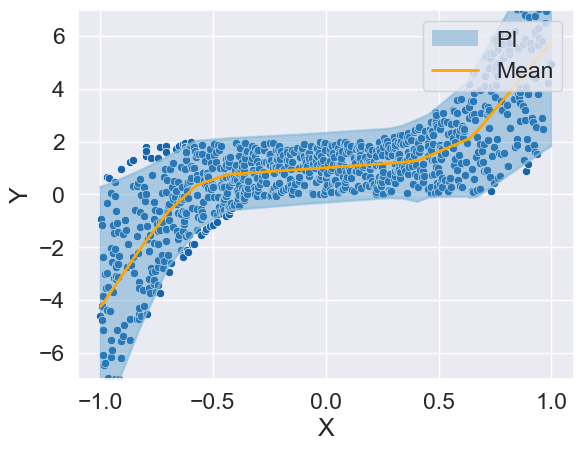

The overall coverage is 0.948
The mean bandwidth for testing data is 4.714715367172681


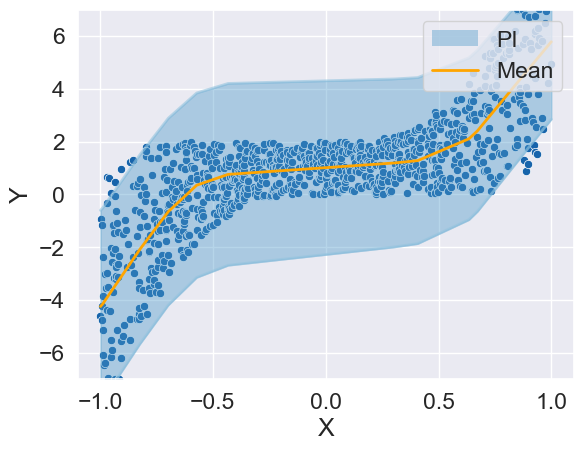

The overall coverage is 0.971
The mean bandwidth for testing data is 10.95054634624025


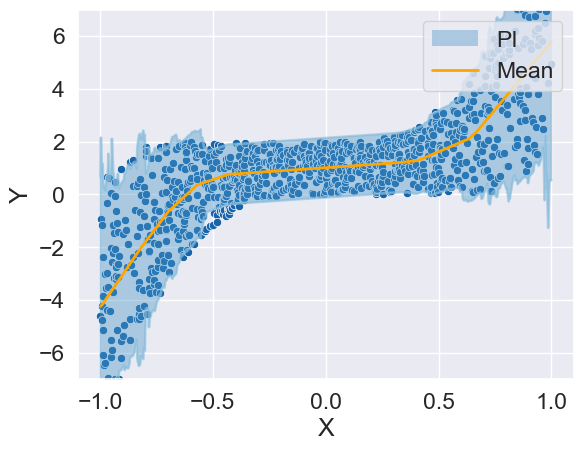

The overall coverage is 0.945
The mean bandwidth for testing data is 5.401704036883912


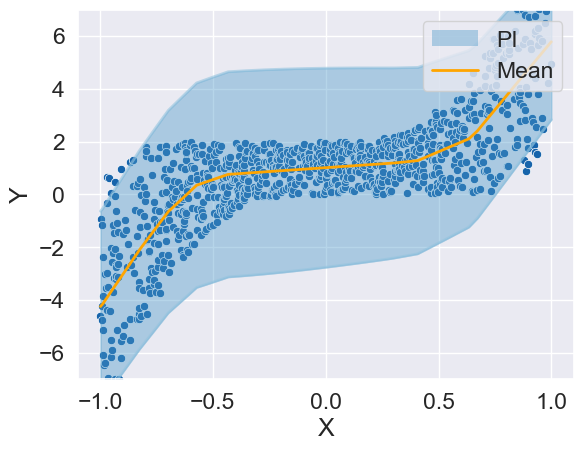

The overall coverage is 0.972
The mean bandwidth for testing data is 13.350961224075935


(0.972, 13.350961224075935)

In [4]:
X,Y = myData(1,n=3000)
UTOPIA(X,Y,n_pre = 1000, n_opt=500, n_adj=500, known_mean ="False")
LQR(X,Y,n_mean = 1000, n_quantile = 1000, known_mean ="False")
SplitCF(X,Y,n_mean = 1000, n_res = 1000,known_mean ="False")
SDP(X,Y,n_pre = 1000, n_opt=100, n_adj=900,known_mean ="False")    

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


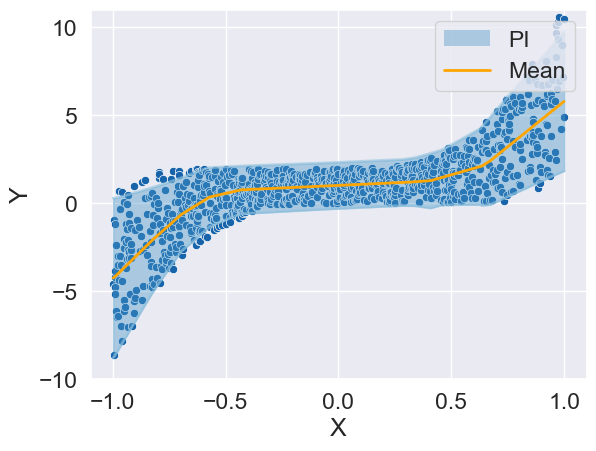

The overall coverage is 0.948
The mean bandwidth for testing data is 4.714715367172681


(0.948, 4.714715367172681)

In [17]:
UTOPIA(X,Y,n_pre = 1000, n_opt=500, n_adj=500, known_mean ="False")